In [4]:
# Clone and cd so relative paths match the repo layout
REPO_URL = "https://github.com/pocolpaolo10tue/atai-2025.git"
REPO_DIR = "atai-2025"
NB_SUBDIR = "practicals/CFD"   # folder that contains this notebook

from pathlib import Path
import os, sys
repo_path = Path("/content")/REPO_DIR
subdir_path = repo_path/NB_SUBDIR

if not repo_path.exists():
    !git clone --depth 1 --branch main {REPO_URL} {repo_path}

assert subdir_path.exists(), f"Missing: {subdir_path}"
%cd {subdir_path}
print("CWD:", os.getcwd())

Cloning into '/content/atai-2025'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 92 (delta 0), reused 86 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 1.82 GiB | 16.56 MiB/s, done.
Updating files: 100% (76/76), done.
/content/atai-2025/practicals/CFD
CWD: /content/atai-2025/practicals/CFD


# Autoregressive Models

In this practical, we'll go over the following topics:
- Autoregressive models and when to use them
- Implementing equivariances in Autoregressive GNNs
- Evaluating scientific AI models

But first, a short introduction on the dataset used for this practical.

![Boids gif](https://github.com/pocolpaolo10tue/atai-2025/blob/main/practicals/boids/figures/boids.gif?raw=1)

## Boids (by Craig Reynolds)

The Boids algorithm, developed by Craig Reynolds [2], aims to replicate the behavior of flocking birds.

The simplest setting, used in this practical, follows three simple rules:

1. Separation: Each boid should steer away from crowding local flockmates (avoiding collisions)
2. Alignment: Each boid should steer towards the average heading of local flockmates
3. Cohesion: Each boid should steer towards the average position of local flockmates

With some parameter tuning, these rules allow for some surprisingly realistic behavior. A gif of one of the simulations is shown above.

### Implementation details

Our dataset consists of 1000 samples of Boids simulations. Each simulation has 25 Boids and continues for 1000 timesteps. The Boids fly around in a 2D grid of 1000 x 1000 units.

In our simulations, Boids steer away from eachother (Separation) if they are within 16 units of eachother. Boids steer towards the average heading/position of all (local) flockmates within 40 units.*
Finally, we use periodic boundary conditions; Boids cannot leave the screen, they re-enter on the other side (pacman style).

* We use Euclidean distance (with PBC) here to compute the distance between boids. For a more detailed explanation, visit [The minimum image convention](https://en.wikibooks.org/wiki/Molecular_Simulation/Periodic_Boundary_Conditions) section of the wikibooks page on PBC.

## Problem setting

Boids simulations feature complex interactions between multiple actors (nodes). The simulation can be chaotic and very sensitive to initial conditions.


This makes it an interesting playground for the models/frameworks discussed in the course. In this practical, we will implement an AR model from scratch, then gradually introduce equivariances and training/evaluation methods.


In [5]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.5 MB/s eta 0:00:00


In [6]:
import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader, InMemoryDataset
import numpy as np
import matplotlib.pyplot as plt
import os

## Data exploration

First let's look at the data structure, and some statistics.

In [7]:
trajectories = [np.load(f"../../data/boids/raw/{f}") for f in os.listdir("../../data/boids/raw") if f.endswith(".npy")]
print(len(trajectories))

26


In [8]:
print("Single trajectory shape:")
print(trajectories[0].shape)
print("The axes and their cardinalities; (Timesteps:1000, Boids:25, (Position X, Position Y, Velocity x, Velocity y):4)")

Single trajectory shape:
(1000, 25, 4)
The axes and their cardinalities; (Timesteps:1000, Boids:25, (Position X, Position Y, Velocity x, Velocity y):4)


In [9]:
# Print the mean, std, min and max of the boid positions, velocities
positions = np.array([t[:, :, :2] for t in trajectories])
velocities = np.array([t[:, :, 2:] for t in trajectories])

print("Position mean, std, min, max:")
# Round to 2 decimal places
print(round(np.mean(positions),2), round(np.std(positions),2), round(np.min(positions), 2), round(np.max(positions), 2))
print()
print("Velocity mean, std, min, max:")
# Round to 2 decimal places
print(round(np.mean(velocities),2), round(np.std(velocities),2), round(np.min(velocities), 2), round(np.max(velocities), 2))

Position mean, std, min, max:
500.32 290.61 0.0 1000.0

Velocity mean, std, min, max:
-0.35 2.96 -6.0 6.0


In [10]:
def plot_state(trajectory, timestep):
    fig, ax = plt.subplots()
    # Plot dots for the boids
    ax.scatter(trajectory[timestep, :, 0], trajectory[timestep, :, 1])
    # plot the boid velocities as arrows
    for i in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        ax.arrow(trajectory[timestep, i, 0], trajectory[timestep, i, 1], trajectory[timestep, i, 2]*5, trajectory[timestep, i, 3]*5)
    return ax

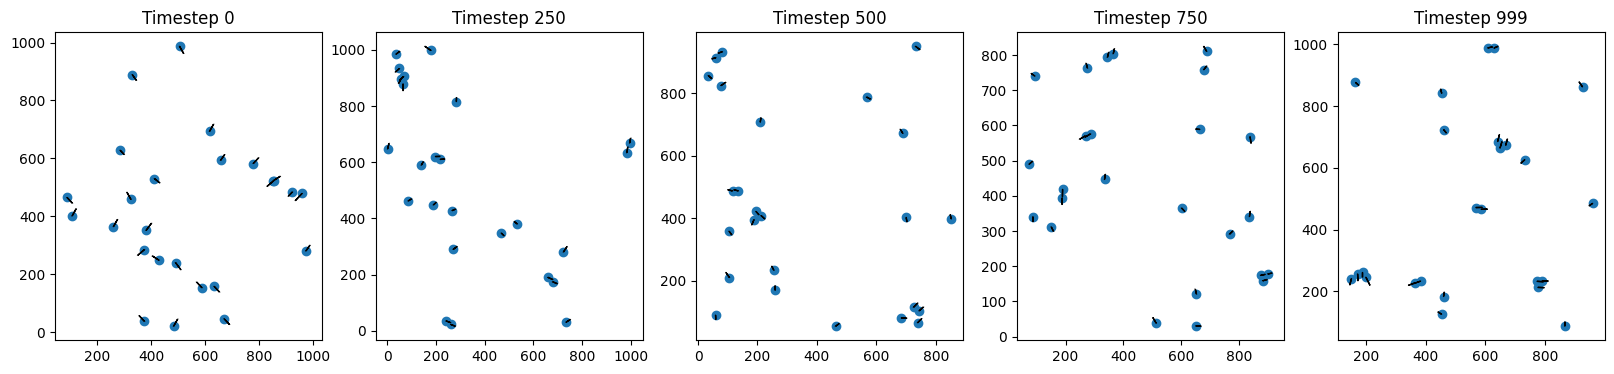

In [11]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

In the plot above, you can see that after some warmup time, the boids start to form flocks. Flocking behavior is a form of inter-node communication, which we will come back to again later.

Thinking back to the Geometric Deep Learning framework, we can identify the following symmetries in the data:

- The boids are equivariant to permutations, ie it does not matter in which order we compute the update rules for the boids.
- Local flocks of boids are equivariant to translation, rotation and reflection.

Following these symmetries, it makes sense to model the boids using a Graph Neural Network (GNN). Specifically, since we are dealing with inter-node communication, we will be implementing a Message Passing GNN here.

But first, we create a `torch_geometric` InMemoryDataset object, to model the data as a graph.

In [12]:
class AR_Boids_Dataset(InMemoryDataset):
    def __init__(self, raw_data_path, processed_data_path, root=None, transform=None, pre_transform=None, post_transform=None, solution_idx_range=(0, 25), timesteps=1000, processed_file_name="AR1_Boids.pt"):
        self.raw_data_path = raw_data_path
        self.processed_data_path = processed_data_path
        self.solution_idx_range = solution_idx_range
        self.timesteps = timesteps
        self.processed_file_name = processed_file_name
        self.pre_transform = pre_transform
        self.transform = transform
        self.post_transform = post_transform
        super(AR_Boids_Dataset, self).__init__(root, transform, pre_transform)
        # Add weights_only=False to handle potential unpickling issues with newer PyTorch versions
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def processed_file_names(self):
        return [self.processed_file_name]

    @property
    def raw_file_names(self):
        return [pfn for pfn in os.listdir(self.raw_data_path) if (self.solution_idx_range[0] <= int(pfn.split("_")[-1][:-4]) < self.solution_idx_range[1])]

    def download(self):
        pass

    def __len__(self):
        return (self.timesteps - 1) * (self.solution_idx_range[1] - self.solution_idx_range[0])

    def process(self):
        data_list = []
        for idx, raw_path in enumerate(self.raw_file_names):
            trajectory = np.load(self.raw_data_path + raw_path)

            if self.transform is not None:
                trajectory = self.transform(trajectory)

            for t in range(trajectory.shape[0] - 1):
                x = torch.tensor(trajectory[t], dtype=torch.float)
                y_temp = torch.tensor(trajectory[t+1], dtype=torch.float)
                # y_temp is (position x, position y, velocity x, velocity y) for the next timestep
                # However, we want delta position and delta velocity
                # Luckily, the delta poisition is just the velocity from the next timestep, and the delta velocity is the acceleration
                # So we can just take the last two elements of y to get the delta velocity
                # First we copy the last two columns of y to the first two columns of y
                y = y_temp.clone()
                y[:, :2] = y_temp[:, 2:]
                # Then we calculate the acceleration
                y[:, 2:] = y_temp[:, 2:] - x[:, 2:]    # (V_x ^ (t+1), V_y ^ (t+1), a_x, a_y)

                # fully connected graph
                edge_index = torch.tensor([[i, j] for i in range(trajectory.shape[1]) for j in range(trajectory.shape[1]) if i != j], dtype=torch.long).t().contiguous()

                if self.post_transform is not None:
                    data = self.post_transform(data)

                data = Data(x=x, y=y, edge_index=edge_index)
                data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_data_path+self.processed_file_name)

    def __getitem__(self, idx):
        return self.get(idx)

    def __repr__(self):
        return f'{self.__class__.__name__}({len(self)})'

In [13]:
train_dataset = AR_Boids_Dataset(raw_data_path="../../data/boids/raw/", processed_data_path="../../data/boids/processed/", root="../../data/boids/", solution_idx_range=(0, 15), timesteps=1000, processed_file_name="AR1_Boids.pt")
validation_dataset = AR_Boids_Dataset(raw_data_path="../../data/boids/raw/", processed_data_path="../../data/boids/processed/", root="../../data/boids/", solution_idx_range=(16, 25), timesteps=1000, processed_file_name="AR1_VAL_Boids.pt")

print(train_dataset)
print(validation_dataset)


data_0 = train_dataset[0]
print(data_0)
print(data_0.keys)
print("Pos x, Pos y, Vel x, Vel y")
print(data_0.x[0,:])

Processing...
Done!
Processing...


AR_Boids_Dataset(14985)
AR_Boids_Dataset(8991)
Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])
<bound method BaseData.keys of Data(x=[25, 4], edge_index=[2, 600], y=[25, 4])>
Pos x, Pos y, Vel x, Vel y
tensor([864., 185.,   3.,   4.])


Done!


## Autoregressive Models
In general, when dealing with simulations spanning multiple timesteps, we can define the learning problem as follows.

Let $X^{0:T-1}$ denote the states spanning across timesteps $t=0$ through $t=T-1$. Given the initial state $X^0$, our goal is to accurately predict the future states $X^{1:T-1}$. In the probabilistic case, we want to learn a model with parameters $\theta$ for the probability distribution $P_\theta(X^{1:T-1}|X^0)$.*

In some systems, such as in the Boids setting, the next state X^{t+1} is only dependent on the current state X^t. Such systems are memoryless, and are often said to be _Markovian_. The Markov property allows us to rewrite the learning task to $P_\theta(X^{1:T-1}|X^0) = \prod_{t=0}^{T-2} P_\theta(X^{t+1} | X^t)$

Here, $P_\theta(X^{t+1} | X^t)$ is the _Autoregressive model_ - literally meaning it is used to autoregressively construct the full trajectory of the system. Note that this model is autoregressive in time; not space.

*: In this practical, we will not be building a probabilistic model. So instead of parameterizing a distribution, we learn a function $f_\theta: X^t \rarr X^{t+1}$.

### Autoregressive set model

Below, we create the simplest AR model for the Boids system; a fully connected GNN (essentially a set model).

Given a fully connected graph $X^t$, representing the Boids system at time $t$; it learns to predict the next state of the system $X^{t+1}$.

Note here that we use all features from the dataset as node features. This causes the model to not be equivariant to some group actions, that are relevant in the Boids setting.

---

Tick the equivariance(s) of this model:

- <input
      type="checkbox"
      id="eq0"
      name="perm"
      value="perm" />
    <label for="eq1">Permutational Equivariance</label>

- <input
      type="checkbox"
      id="eq1"
      name="space"
      value="space" />
    <label for="eq1">Space Translation Equivariance</label>

- <input
      type="checkbox"
      id="eq2"
      name="time"
      value="time" />
    <label for="eq2">Time Translation Equivariance</label>

- <input
      type="checkbox"
      id="eq3"
      name="rot"
      value="rot" />
    <label for="eq3">Rotation/Reflection Equivariance</label>

In [14]:
class AR_Set_Model(torch.nn.Module):
    def __init__(self, node_dim=4, emb_dim=16, out_dim=4):
        super(AR_Set_Model, self).__init__()
        self.node_embedding = torch.nn.Linear(node_dim, emb_dim)
        self.conv1 = torch_geometric.nn.GCNConv(emb_dim, emb_dim)
        self.conv2 = torch_geometric.nn.GCNConv(emb_dim, out_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.node_embedding(x)
        x = torch.nn.functional.relu(x)
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [15]:
class Trainer:
    def __init__(self, model, train_dataset, validation_dataset, batch_size=1, lr=0.0001, epochs=100, loss_fn=torch.nn.MSELoss(), model_name= "01-AR-Set-Model.pt"):
        """
        Simple Trainer class to train a PyTorch (geometric) model on a dataset.

        Args:
            model: PyTorch model to train
            train_dataset: PyTorch dataset to train on
            validation_dataset: PyTorch dataset to validate on
            batch_size: Batch size for training
            lr: Learning rate
            epochs: Number of epochs to train for
            loss_fn: Loss function to use
        """
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        self.train_loader = self.make_data_loader(self.train_dataset)
        self.validation_loader = self.make_data_loader(self.validation_dataset, shuffle=False)

    def make_data_loader(self, dataset, shuffle=True):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)

    def train_loop(self):
        """
        Train loop for the model
        """
        best_model_loss = np.inf
        for epoch in range(self.epochs):
            # Train the model
            self.model.train()
            mean_train_loss = 0
            for i, data in enumerate(self.train_loader):
                data = self.train_dataset[i].to(self.device)
                self.optimizer.zero_grad()
                out = self.model(data)
                loss = self.loss_fn(out, data.y)
                loss.backward()
                self.optimizer.step()
                mean_train_loss += loss.item()
            mean_train_loss /= i

            # Validate the model
            self.model.eval()
            mean_val_loss = 0
            with torch.no_grad():
                for i, data in enumerate(self.validation_loader):
                    data = self.validation_dataset[i].to(self.device)
                    out = self.model(data)
                    loss = self.loss_fn(out, data.y)
                    mean_val_loss += loss.item()
                mean_val_loss /= i

            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(), f"../../models/{self.model_name}")

            print(f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}")



In [16]:
model = AR_Set_Model(emb_dim=64)
trainer = Trainer(model, train_dataset, validation_dataset, batch_size=8, loss_fn=torch.nn.MSELoss(), epochs=100, model_name="01-AR-Set-Model.pt")
trainer.train_loop()

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, Mean Train Loss: 1246.7216689216218, Mean Validation Loss: 145.49107149044318
Epoch 1, Mean Train Loss: 12.815849668191705, Mean Validation Loss: 113.05256101305955
Epoch 2, Mean Train Loss: 8.776178287683294, Mean Validation Loss: 119.13678729438612
Epoch 3, Mean Train Loss: 7.715893123726506, Mean Validation Loss: 108.46364023933852
Epoch 4, Mean Train Loss: 7.798002472804691, Mean Validation Loss: 104.45221660355851
Epoch 5, Mean Train Loss: 8.378680583505279, Mean Validation Loss: 104.0570568405722
Epoch 6, Mean Train Loss: 8.647679835287441, Mean Validation Loss: 99.29179926164853
Epoch 7, Mean Train Loss: 8.739531174994253, Mean Validation Loss: 98.40064855186618
Epoch 8, Mean Train Loss: 8.942527572483668, Mean Validation Loss: 82.97412280407954
Epoch 9, Mean Train Loss: 8.316804931371275, Mean Validation Loss: 72.39769527854817
Epoch 10, Mean Train Loss: 7.480931292545076, Mean Validation Loss: 63.087075883112945
Epoch 11, Mean Train Loss: 7.114831796127784, Mean Valid

### Q1: Implementing rollout code

We have a working model now to predict $\hat{X}^{t+1}$ given $X^t$. However, we of course want to be able to generate trajectories longer than one step (ie for i steps: $\hat{X}^{t+1:t+i}$), given $X^t$.

We sometimes call this a `rollout` - essentially a multi-step prediction.

Q1: Complete the method below, which generates a rollout of `timesteps` steps, for a given model `model`, and dataset `dataset` *.

HINT: What should happen if the position $x_i, y_i$ of boid $i$ are predicted to move $dx_i, dy_i$, such that $x_i + dx_i > \text{width}$ or $y_i + dy_i > \text{height}$?

*: If you check the cell below the next cell, we already made a dataset for you that only contains initial positions :)

In [17]:
def compute_ar_set_model_rollouts(model, dataset, timesteps=1000, device='cuda', mode="residual", width = 1000, height = 1000):
    """
    Predict the rollouts of the model on the dataset starting from the idx

    Args:
        model: PyTorch model
        dataset: PyTorch dataset (should contain initial states)
        timesteps: Number of timesteps to predict
        device: Device to run the model on
        mode: "residual" or "direct"
        - In the solution above, we used the "residual" mode, where the model predicts the change in position and change in velocity
        - In the "direct" mode, the model predicts the position and velocity directly (if you do not intend to use this mode, you can ignore this argument)
        width: Width of the PBC box
        height: Height of the PBC box
    Returns:
        rollouts: Rollouts of the model on the dataset
        - Should be a torch tensor of shape (Batch, Timesteps, Boids, Node_dim)
    """
    rollouts = torch.empty((len(dataset), timesteps, dataset[0].x.shape[0], dataset[0].x.shape[1]), device=device)
    print(rollouts.shape)

    # ~ ^ ~ ^ ~ ^ ~ ^ ~ ^ ~ ^
    #     Your code here
    # ~ ^ ~ ^ ~ ^ ~ ^ ~ ^ ~ ^
    for i in range(len(dataset)):

        data = dataset[i].to(device)
        current_state = data.x.unsqueeze(0)


        rollouts[i, 0, :, :] = current_state.squeeze(0)

        for t in range(1, timesteps):
            # Predict the next state
            with torch.no_grad():
                predicted_delta = model(Data(x=current_state.squeeze(0), edge_index=data.edge_index.to(device))).unsqueeze(0) # Add batch dimension


            if mode == "residual":
                new_velocity = predicted_delta[:, :, :2]
                delta_position = new_velocity
                new_position = current_state[:, :, :2] + delta_position
                new_velocity_from_delta = current_state[:, :, 2:] + predicted_delta[:, :, 2:]
                current_state = torch.cat([new_position, new_velocity_from_delta], dim=-1)


            elif mode == "direct":

                current_state = predicted_delta
            current_state[:, :, 0] = torch.remainder(current_state[:, :, 0], width)
            current_state[:, :, 1] = torch.remainder(current_state[:, :, 1], height)
            rollouts[i, t, :, :] = current_state.squeeze(0)


    return rollouts

In [18]:
def keep_01(data):
    return data[0:2, :, :]

initial_states_validation_dataset = AR_Boids_Dataset(
    raw_data_path="../../data/boids/raw/",
    processed_data_path="../../data/boids/processed/",
    root="../../data/boids/",
    solution_idx_range=(16, 25),
    timesteps=2,
    processed_file_name="AR1_VAL_init.pt",
    transform=keep_01
    )

ar_set_model = AR_Set_Model(emb_dim=64)
ar_set_model.load_state_dict(torch.load("../../models/01-AR-Set-Model.pt"))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ar_set_model.to(device)
ar_set_model.eval()

ar_set_model_rollout = compute_ar_set_model_rollouts(ar_set_model, initial_states_validation_dataset, timesteps=1000, device=device)

torch.Size([9, 1000, 25, 4])


Processing...
Done!


We'll evaluate these rollouts later.

### Quick recap on equivariances

<img src="https://github.com/pocolpaolo10tue/atai-2025/blob/main/practicals/boids/figures/boids-translational-equivariance.png?raw=1" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>
<img src="https://github.com/pocolpaolo10tue/atai-2025/blob/main/practicals/boids/figures/boids-rotational-equivariance.png?raw=1" alt="drawing" width="250" style="background-color: white; padding: 50px;"/>

The figures above show the equivariances of the Boids system. The system is equivariant to all E(n) transformations; translation,
rotation and reflection.*

Formally, we say a function $f: X \rarr Y$ is _equivariant_ to a group action or transformation $T: X \rarr X$ if there is an equivalent transformation $S: Y \rarr Y$ on the output space of the function such that

$f(T(x)) = S(f(x))$ for each $x \in X$

We won't go into the formal definitions of each equivariance, but if you're interested you can check out the [E(n) Equivariant Graph Neural Networks](https://arxiv.org/pdf/2102.09844) paper [3], the equivariant model is based on.

*: Excluding time translation equivariance, which states that there is no dependence on the time of the system, only the state.

*: Also excluding permutational equivariance; the order of the nodes does not matter.

## Towards Equivariant AR-GNNs
The above model is **not** equivariant to translations in space! This is because we use absolute coordinates as _node features_, which creates a dependence on the absolute coordinate system. Instead, if we do not use the absolute positions as node features - and include the PBC distance as _edge features_ - the predictions will be space translation equivariant.

Let's implement this!

Before, we were not using the fact that boids only affect eachother within a certain radius, since we used a fully connected graph without edge weights.

Before blindly jumping into the new dataset code, let's investigate this behavior.

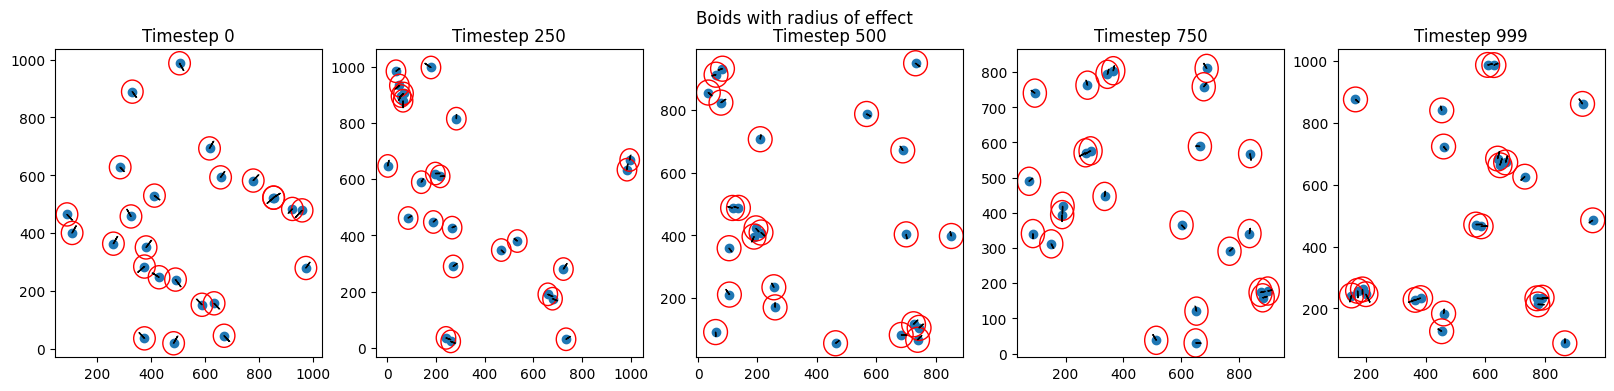

In [19]:
# Plot timesteps 0, 250, 500, 750, 999 for the first trajectory
trajectory = trajectories[0]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle("Boids with radius of effect")
radius = 40

for i, t in enumerate([0, 250, 500, 750, 999]):
    axs[i].set_title(f"Timestep {t}")
    # Plot dots for the boids
    axs[i].scatter(trajectory[t, :, 0], trajectory[t, :, 1])
    # Draw a red circle around each boid to indicate the radius
    for j in range(trajectory.shape[1]):
        circle = plt.Circle((trajectory[t, j, 0], trajectory[t, j, 1]), radius, color='r', fill=False)
        axs[i].add_artist(circle)
    # plot the boid velocities as arrows
    for j in range(trajectory.shape[1]):
        # NOTE: The arrows are made larger for effect
        axs[i].arrow(trajectory[t, j, 0], trajectory[t, j, 1], trajectory[t, j, 2]*5, trajectory[t, j, 3]*5)
plt.show()

## Q2 E(n) Equivariant Graph Neural Networks

In Satorras, Hoogeboom, Welling's paper [3] with the same name, they introduce a relatively simple model that is equivariant to E(n) transformations.
You can check the official [implementation](https://github.com/vgsatorras/egnn).
implement the E(n)-Equivariant Graph Neural Networks (EGNN) model from scratch.

In [20]:
# EGNN
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
class MLP(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, num_layers=2, act=nn.SiLU):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden]*(num_layers-1) + [out_dim]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(act())
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)
class EGNNLayer(MessagePassing):
    """
    EGNN layer:
      m_ij = phi_e(h_i, h_j, ||x_i - x_j||^2)
      h_i' = h_i + phi_h(h_i, sum_j m_ij)
      x_i' = x_i + sum_j (x_i - x_j) * phi_x(m_ij) / (1 + ||x_i - x_j||)
    Uses only relative coords/distances -> E(n)-equivariant.
    """
    def __init__(self, h_dim, m_dim=64, coord_norm=True, aggr='add'):
        super().__init__(aggr=aggr)
        self.coord_norm = coord_norm
        self.phi_e = MLP(in_dim=2*h_dim + 1, hidden=m_dim, out_dim=m_dim, num_layers=2)
        self.phi_x = MLP(in_dim=m_dim, hidden=m_dim, out_dim=1, num_layers=2)
        self.phi_h = MLP(in_dim=h_dim + m_dim, hidden=m_dim, out_dim=h_dim, num_layers=2)

    def forward(self, h, x, edge_index):
        # propagate -> calls message -> aggregate -> update
        dx, h_out = self.propagate(edge_index, x=x, h=h, size=None)
        x = x + dx
        h = h_out
        return h, x

    def message(self, x_i, x_j, h_i, h_j):
        diff = x_i - x_j
        r2 = (diff * diff).sum(dim=-1, keepdim=True)
        m_ij = self.phi_e(torch.cat([h_i, h_j, r2], dim=-1))
        delta_scalar = self.phi_x(m_ij)
        if self.coord_norm:
            r = torch.sqrt(r2 + 1e-8)
            delta = diff * (delta_scalar / (1.0 + r))
        else:
            delta = diff * delta_scalar
        return m_ij, delta

    def aggregate(self, inputs, index, dim_size=None):
        # inputs is a tuple (m_ij, delta_ij); sum over neighbors j->i
        m, delta = inputs
        if dim_size is None:
            dim_size = index.max().item() + 1
        m_agg = torch.zeros((dim_size, m.size(-1)), device=m.device)
        d_agg = torch.zeros((dim_size, delta.size(-1)), device=delta.device)
        m_agg.index_add_(0, index, m)
        d_agg.index_add_(0, index, delta)
        return m_agg, d_agg

    def update(self, aggr_out, h):
        m_agg, d_agg = aggr_out
        h_new = self.phi_h(torch.cat([h, m_agg], dim=-1))
        h_new = h + h_new
        return d_agg, h_new
class EGNN_AR_Model(nn.Module):
    """
    EGNN-based autoregressive head for Boids.
    Treat positions as coordinates, velocities as node features.
    Output: (N,4) to match your target y:
      y[:, :2] = v^{t+1}
      y[:, 2:] = a = v^{t+1} - v^t
    """
    def __init__(self, coord_dim=2, feat_dim=2, h_dim=64, m_dim=64, n_layers=3, out_dim=4, edge_radius=None):
        super().__init__()
        self.coord_dim = coord_dim
        self.edge_radius = edge_radius
        self.embed = nn.Linear(feat_dim, h_dim)
        self.layers = nn.ModuleList([EGNNLayer(h_dim=h_dim, m_dim=m_dim) for _ in range(n_layers)])
        self.head = MLP(in_dim=h_dim, hidden=h_dim, out_dim=out_dim, num_layers=2)

    def forward(self, data):
        pos = data.x[:, :self.coord_dim]
        vel = data.x[:, self.coord_dim:]
        h = torch.relu(self.embed(vel))

        edge_index = data.edge_index

        if self.edge_radius is not None and edge_index is not None and edge_index.numel() > 0:
            with torch.no_grad():
                diff = pos[edge_index[0]] - pos[edge_index[1]]
                r2 = (diff * diff).sum(dim=-1)
                keep = r2 <= (self.edge_radius ** 2)
            edge_index = edge_index[:, keep]


        for layer in self.layers:
            h, pos = layer(h=h, x=pos, edge_index=edge_index)

        out = self.head(h)   # (N,4)
        return out


In [21]:
model = EGNN_AR_Model(h_dim=64, m_dim=64, n_layers=4, out_dim=4, edge_radius=40)  # edge_radius optional
trainer = Trainer(model, train_dataset, validation_dataset,
                  batch_size=8, lr=1e-4, epochs=40,
                  loss_fn=torch.nn.MSELoss(), model_name="02-EGNN-Boids.pt")
trainer.train_loop()


Using device: cuda
Epoch 0, Mean Train Loss: 0.2713974013352032, Mean Validation Loss: 0.014989421831880127
Epoch 1, Mean Train Loss: 0.008418732393002564, Mean Validation Loss: 0.009124720147342313
Epoch 2, Mean Train Loss: 0.007744004072228524, Mean Validation Loss: 0.00678568201551947
Epoch 3, Mean Train Loss: 0.007210735944005871, Mean Validation Loss: 0.006179951780491433
Epoch 4, Mean Train Loss: 0.0069576763693693635, Mean Validation Loss: 0.006267392468507686
Epoch 5, Mean Train Loss: 0.006855132055407604, Mean Validation Loss: 0.006991673411344504
Epoch 6, Mean Train Loss: 0.0066484421682413836, Mean Validation Loss: 0.006350739359173954
Epoch 7, Mean Train Loss: 0.0065203645616428935, Mean Validation Loss: 0.006091500454939295
Epoch 8, Mean Train Loss: 0.006323718851474873, Mean Validation Loss: 0.006025316187220801
Epoch 9, Mean Train Loss: 0.00621021220854236, Mean Validation Loss: 0.006030723412916353
Epoch 10, Mean Train Loss: 0.006130093059959253, Mean Validation Loss: 0

In [27]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'


ar_no_pf = AR_Set_Model(emb_dim=64).to(device)
ar_no_pf.load_state_dict(torch.load("../../models/01-AR-Set-Model.pt", map_location=device))
ar_no_pf.eval()


egnn_no_pf = EGNN_AR_Model(h_dim=64, m_dim=64, n_layers=4, out_dim=4, edge_radius=40).to(device)
egnn_no_pf.load_state_dict(torch.load("../../models/02-EGNN-Boids.pt", map_location=device))
egnn_no_pf.eval()


EGNN_AR_Model(
  (embed): Linear(in_features=2, out_features=64, bias=True)
  (layers): ModuleList(
    (0-3): 4 x EGNNLayer()
  )
  (head): MLP(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)

Loaded GT shape: torch.Size([9, 1000, 25, 4])


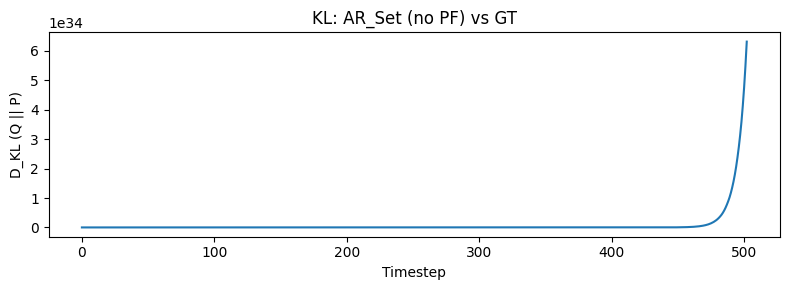

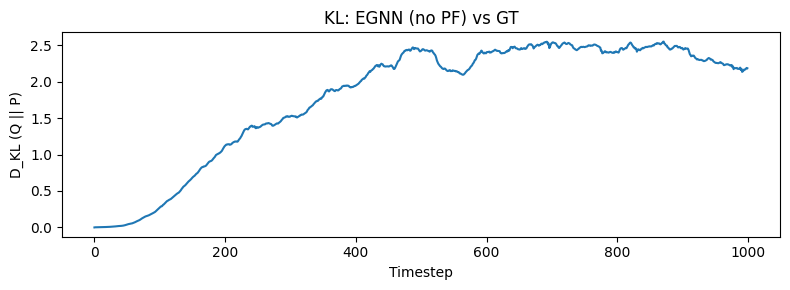

Mean KL (AR no PF):   nan
Mean KL (EGNN no PF): 1.8044956922531128


In [31]:

import os, numpy as np, torch, matplotlib.pyplot as plt


raw_dir = "../../data/boids/raw/"
def _idx_from_name(fn):
    try:
        return int(fn.split("_")[-1].split(".")[0])
    except Exception:
        return None

all_files = [f for f in os.listdir(raw_dir) if f.endswith(".npy")]
val_files = [f for f in all_files if (_idx_from_name(f) is not None and 16 <= _idx_from_name(f) < 25)]
val_files.sort(key=lambda f: _idx_from_name(f))
gt_list = [np.load(os.path.join(raw_dir, f)) for f in val_files]
validation_trajectories = torch.tensor(np.stack(gt_list, axis=0), dtype=torch.float)
print("Loaded GT shape:", validation_trajectories.shape)  # expect [9, 1000, 25, 4]


def compute_velocity_distributions(vel, timesteps=None, eps=1e-6):
    """
    vel: [B, T, N, 2] -> returns list of Normal(mean_t, std_t) for t=0..T-1
    """
    if timesteps is None: timesteps = vel.shape[1]
    dists = []
    for t in range(timesteps):
        v_t = vel[:, t].reshape(-1)
        mean = v_t.mean()
        std = v_t.std().clamp_min(eps)
        dists.append(torch.distributions.Normal(mean, std))
    return dists

def kl_curve(q_list, p_list):
    vals = [torch.distributions.kl_divergence(q, p) for q, p in zip(q_list, p_list)]
    return torch.stack(vals)

def plot_kl(kl_vals, title="KL divergence per timestep"):
    xs = torch.arange(len(kl_vals)).cpu().numpy()
    ys = kl_vals.detach().cpu().numpy()
    plt.figure(figsize=(8,3))
    plt.plot(xs, ys)
    plt.xlabel("Timestep")
    plt.ylabel("D_KL (Q || P)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


dists_GT   = compute_velocity_distributions(validation_trajectories[:,:,:,2:])
assert 'roll_ar' in globals() and 'roll_egnn' in globals(), "Run the rollout cells first."

dists_AR   = compute_velocity_distributions(roll_ar[:,:,:,2:])
dists_EGNN = compute_velocity_distributions(roll_egnn[:,:,:,2:])


kl_AR   = kl_curve(dists_AR,   dists_GT)
kl_EGNN = kl_curve(dists_EGNN, dists_GT)

plot_kl(kl_AR,   title="KL: AR_Set (no PF) vs GT")
plot_kl(kl_EGNN, title="KL: EGNN (no PF) vs GT")

print("Mean KL (AR no PF):  ", float(kl_AR.mean()))
print("Mean KL (EGNN no PF):", float(kl_EGNN.mean()))



## Q3 Push-forward training

Implement the push-forward training mechanism for the AR-Set-Model and the EGNN developed in Q2

### Push-forward for AR_Set_model

In [22]:
###
 # TODO: TODO: TODO: TODO: TODO:
        """
        Your code goes here

        """
###

IndentationError: unexpected indent (ipython-input-1820560880.py, line 3)

In [23]:
#  Push-forward for AR
import os, math, torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
import torch_geometric


class AR_Set_Model_Norm(torch.nn.Module):
    def __init__(self, node_dim=4, emb_dim=256, out_dim=4, pos_scale=1000.0, p_drop=0.2):
        super().__init__()
        self.pos_scale = pos_scale
        self.lin_in = torch.nn.Linear(node_dim, emb_dim)
        self.bn1 = torch.nn.BatchNorm1d(emb_dim)
        self.conv1 = torch_geometric.nn.GCNConv(emb_dim, emb_dim)
        self.bn2 = torch.nn.BatchNorm1d(emb_dim)
        self.conv2 = torch_geometric.nn.GCNConv(emb_dim, emb_dim)
        self.bn3 = torch.nn.BatchNorm1d(emb_dim)
        self.lin_out = torch.nn.Linear(emb_dim, out_dim)
        self.drop = torch.nn.Dropout(p_drop)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.clone()
        x[:, :2] = x[:, :2] / self.pos_scale  # normalize positions only

        x = self.lin_in(x)
        x = torch.relu(self.bn1(x))
        x = self.drop(x)

        x = self.conv1(x, edge_index)
        x = torch.relu(self.bn2(x))
        x = self.drop(x)

        x = self.conv2(x, edge_index)
        x = torch.relu(self.bn3(x))
        x = self.drop(x)

        x = self.lin_out(x)
        return x


class WeightedMSE(nn.Module):
    def __init__(self, w=(1.0, 1.0, 0.5, 0.5)):
        super().__init__()
        self.register_buffer("w", torch.tensor(w, dtype=torch.float32))
    def forward(self, pred, target):
        return ((self.w * (pred - target) ** 2).mean())


def _make_e2_rotation_reflection(apply_reflection=True, device='cpu'):
    theta = torch.rand((), device=device) * 2 * math.pi
    c, s = torch.cos(theta), torch.sin(theta)
    R = torch.stack([torch.stack([ c, -s]), torch.stack([ s,  c])])  # (2,2)
    if apply_reflection and (torch.rand((), device=device) < 0.5):
        F = torch.tensor([[1., 0.],[0., -1.]], device=device)
        R = F @ R
    return R  # (2,2)

def _apply_e2_to_state(x, R, t=None, width=1000, height=1000):
    """
    x: (N,4) = [pos_x, pos_y, vel_x, vel_y]
    R: (2,2) rotation/reflection
    t: (2,) translation or None (when translations are disabled)
    """
    pos = x[:, :2] @ R.T
    if t is not None:
        pos = pos + t
    vel = x[:, 2:] @ R.T
    pos[:, 0] = pos[:, 0] % width
    pos[:, 1] = pos[:, 1] % height
    return torch.cat([pos, vel], dim=-1)

def _apply_e2_to_output(out, R):
    """
    out: (N,4) = [v_next_x, v_next_y, a_x, a_y]
    Both velocity and acceleration transform as vectors: rotate/reflect only.
    """
    v_next = out[:, :2] @ R.T
    acc    = out[:, 2:] @ R.T
    return torch.cat([v_next, acc], dim=-1)

def transform_data_e2(data: Data, width=1000, height=1000,
                      apply_reflection=True, use_translation=False):
    """
    Returns data_T (Data) and R. For AR we set use_translation=False to avoid PF blow-ups.
    Preserves batch attribute if present.
    """
    device = data.x.device
    R = _make_e2_rotation_reflection(apply_reflection=apply_reflection, device=device)
    t = None
    if use_translation:
        t = torch.tensor([torch.rand((), device=device)*width,
                          torch.rand((), device=device)*height], device=device)
    x_T = _apply_e2_to_state(data.x, R, t, width=width, height=height)
    data_T = Data(x=x_T, edge_index=data.edge_index, y=getattr(data, "y", None))
    if hasattr(data, "batch"):
        data_T.batch = data.batch  # keep graph boundaries for batched data
    return data_T, R

def pushforward_step(model, data, loss_fn, lambda_pf=1.0,
                     width=1000, height=1000,
                     apply_reflection=True, use_translation=False):
    """
    loss = MSE(model(x), y) + λ * MSE( model(T·x),  S·model(x) )
    For AR baseline, T excludes translations (use_translation=False).
    """
    pred = model(data)
    loss_sup = loss_fn(pred, data.y)

    data_T, R = transform_data_e2(
        data, width=width, height=height,
        apply_reflection=apply_reflection, use_translation=use_translation
    )
    with torch.no_grad():
        pred_ref = _apply_e2_to_output(pred, R)

    pred_T = model(data_T)


    if pred_T.shape != pred_ref.shape:
        raise RuntimeError(f"PF shape mismatch: pred_T {pred_T.shape} vs pred_ref {pred_ref.shape}")

    loss_pf = loss_fn(pred_T, pred_ref)
    loss = loss_sup + lambda_pf * loss_pf
    return loss, loss_sup.detach(), loss_pf.detach()


class PFTrainer:
    def __init__(self, model, train_dataset, validation_dataset,
                 batch_size=8, lr=5e-5, epochs=50,
                 loss_fn=torch.nn.MSELoss(),
                 lambda_pf=0.05,
                 width=1000, height=1000,
                 apply_reflection=True,
                 use_translation=False,
                 model_name="03-AR-Set-Norm-PF.pt"):
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.lambda_pf = lambda_pf
        self.width = width
        self.height = height
        self.apply_reflection = apply_reflection
        self.use_translation = use_translation
        self.model_name = model_name

        os.makedirs("../../models", exist_ok=True)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)  # add weight_decay=1e-5 if needed

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader   = DataLoader(self.validation_dataset,  batch_size=self.batch_size, shuffle=False)

    def _run_epoch(self, loader, train=True):
        if train: self.model.train()
        else:     self.model.eval()

        total, n = 0.0, 0
        sup_tot, pf_tot = 0.0, 0.0
        with torch.set_grad_enabled(train):
            for data in loader:
                data = data.to(self.device)
                if train: self.optimizer.zero_grad()

                loss, loss_sup, loss_pf = pushforward_step(
                    self.model, data, self.loss_fn, lambda_pf=self.lambda_pf,
                    width=self.width, height=self.height,
                    apply_reflection=self.apply_reflection,
                    use_translation=self.use_translation
                )

                if train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    self.optimizer.step()

                total += float(loss.item())
                sup_tot += float(loss_sup.item())
                pf_tot  += float(loss_pf.item())
                n += 1

        return total/max(1,n), sup_tot/max(1,n), pf_tot/max(1,n)

    def train_loop(self):
        best_val = float('inf')
        for epoch in range(1, self.epochs+1):
            tr_all, tr_sup, tr_pf = self._run_epoch(self.train_loader, train=True)
            va_all, va_sup, va_pf = self._run_epoch(self.val_loader, train=False)

            if va_all < best_val:
                best_val = va_all
                torch.save(self.model.state_dict(), f"../../models/{self.model_name}")

            print(f"Epoch {epoch:03d} | "
                  f"train total {tr_all:.5f} (sup {tr_sup:.5f} + pf {tr_pf:.5f}) | "
                  f"val total {va_all:.5f} (sup {va_sup:.5f} + pf {va_pf:.5f})")


ar_pf = AR_Set_Model_Norm()
PFTrainer(
    model=ar_pf,
    train_dataset=train_dataset,
    validation_dataset=validation_dataset,
    batch_size=16,
    lr=3e-4,
    epochs=30,
    loss_fn=torch.nn.MSELoss(),
    lambda_pf=0.05,
    width=1000, height=1000,
    apply_reflection=True,
    use_translation=False,
    model_name="03-AR-NormWide-PF.pt"
).train_loop()


Using device: cuda
Epoch 001 | train total 3.34403 (sup 3.33395 + pf 0.20169) | val total 3.43059 (sup 3.42938 + pf 0.02422)
Epoch 002 | train total 3.31316 (sup 3.30416 + pf 0.17987) | val total 3.44816 (sup 3.44524 + pf 0.05830)
Epoch 003 | train total 3.30661 (sup 3.29806 + pf 0.17101) | val total 3.41761 (sup 3.41680 + pf 0.01612)
Epoch 004 | train total 3.29544 (sup 3.28698 + pf 0.16909) | val total 3.43616 (sup 3.43433 + pf 0.03663)
Epoch 005 | train total 3.29993 (sup 3.29172 + pf 0.16412) | val total 3.43365 (sup 3.43240 + pf 0.02505)
Epoch 006 | train total 3.29912 (sup 3.29061 + pf 0.17027) | val total 3.43200 (sup 3.43038 + pf 0.03238)
Epoch 007 | train total 3.29058 (sup 3.28214 + pf 0.16869) | val total 3.45308 (sup 3.45066 + pf 0.04845)
Epoch 008 | train total 3.29238 (sup 3.28396 + pf 0.16836) | val total 3.41578 (sup 3.41500 + pf 0.01559)
Epoch 009 | train total 3.28861 (sup 3.28016 + pf 0.16906) | val total 3.45682 (sup 3.45289 + pf 0.07868)
Epoch 010 | train total 3.2

### Push-forward for EGNN

In [ ]:
###
 # TODO: TODO: TODO: TODO: TODO:
        """
        Your code goes here

        """
###

In [24]:
# EGNN + Push-Forward (self-contained)

import os, math, torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing
import torch_geometric

class MLP(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, num_layers=2, act=nn.SiLU):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden]*(num_layers-1) + [out_dim]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(act())
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class EGNNLayer(MessagePassing):
    """
    E(n)-equivariant message passing:
      m_ij = phi_e(h_i, h_j, ||x_i - x_j||^2)
      h_i' = h_i + phi_h(h_i, sum_j m_ij)
      x_i' = x_i + sum_j (x_i - x_j) * phi_x(m_ij) / (1 + ||x_i - x_j||)
    Uses only relative coords and scalar distances -> rotation/reflection/translation equivariant.
    """
    def __init__(self, h_dim, m_dim=64, coord_norm=True, aggr='add'):
        super().__init__(aggr=aggr)
        self.coord_norm = coord_norm
        self.phi_e = MLP(in_dim=2*h_dim + 1, hidden=m_dim, out_dim=m_dim, num_layers=2)
        self.phi_x = MLP(in_dim=m_dim, hidden=m_dim, out_dim=1, num_layers=2)
        self.phi_h = MLP(in_dim=h_dim + m_dim, hidden=m_dim, out_dim=h_dim, num_layers=2)

    def forward(self, h, x, edge_index):
        dx, h_out = self.propagate(edge_index, x=x, h=h, size=None)
        x = x + dx
        h = h_out
        return h, x

    def message(self, x_i, x_j, h_i, h_j):
        diff = x_i - x_j
        r2 = (diff * diff).sum(dim=-1, keepdim=True)
        m_ij = self.phi_e(torch.cat([h_i, h_j, r2], dim=-1))
        delta_scalar = self.phi_x(m_ij)
        if self.coord_norm:
            r = torch.sqrt(r2 + 1e-8)
            delta = diff * (delta_scalar / (1.0 + r))
        else:
            delta = diff * delta_scalar
        return m_ij, delta

    def aggregate(self, inputs, index, dim_size=None):
        m, delta = inputs
        if dim_size is None:
            dim_size = int(index.max().item()) + 1 if index.numel() > 0 else 0
        m_agg = torch.zeros((dim_size, m.size(-1)), device=m.device)
        d_agg = torch.zeros((dim_size, delta.size(-1)), device=delta.device)
        if index.numel() > 0:
            m_agg.index_add_(0, index, m)
            d_agg.index_add_(0, index, delta)
        return m_agg, d_agg

    def update(self, aggr_out, h):
        m_agg, d_agg = aggr_out
        h_new = self.phi_h(torch.cat([h, m_agg], dim=-1))
        h_new = h + h_new
        return d_agg, h_new

class EGNN_AR_Model(nn.Module):
    """
    EGNN autoregressive head for Boids.
    Assumes data.x = [pos_x, pos_y, vel_x, vel_y].
    Returns (N,4) to match your target y = [v^{t+1}_x, v^{t+1}_y, a_x, a_y].
    """
    def __init__(self, coord_dim=2, feat_dim=2, h_dim=64, m_dim=64, n_layers=4, out_dim=4, edge_radius=40):
        super().__init__()
        self.coord_dim = coord_dim
        self.edge_radius = edge_radius
        self.embed = nn.Linear(feat_dim, h_dim)
        self.layers = nn.ModuleList([EGNNLayer(h_dim=h_dim, m_dim=m_dim) for _ in range(n_layers)])
        self.head = MLP(in_dim=h_dim, hidden=h_dim, out_dim=out_dim, num_layers=2)

    def forward(self, data: Data):
        pos = data.x[:, :self.coord_dim]
        vel = data.x[:, self.coord_dim:]
        h = torch.relu(self.embed(vel))

        edge_index = data.edge_index

        if self.edge_radius is not None and edge_index is not None and edge_index.numel() > 0:
            with torch.no_grad():
                diff = pos[edge_index[0]] - pos[edge_index[1]]
                r2 = (diff * diff).sum(dim=-1)
                keep = r2 <= (self.edge_radius ** 2)
            edge_index = edge_index[:, keep]

        for layer in self.layers:
            h, pos = layer(h=h, x=pos, edge_index=edge_index)

        out = self.head(h)
        return out

def _sample_R(apply_reflection=True, device='cpu'):
    theta = torch.rand((), device=device) * 2 * math.pi
    c, s = torch.cos(theta), torch.sin(theta)
    R = torch.stack([torch.stack([ c, -s]), torch.stack([ s,  c])])  # (2,2)
    if apply_reflection and (torch.rand((), device=device) < 0.5):
        F = torch.tensor([[1., 0.],[0., -1.]], device=device)
        R = F @ R
    return R

def _apply_E2_to_state(x, R, t=None, width=1000, height=1000):
    # x: (N,4) = [pos_x, pos_y, vel_x, vel_y]
    pos = x[:, :2] @ R.T
    if t is not None:
        pos = pos + t
    vel = x[:, 2:] @ R.T
    pos[:, 0] = pos[:, 0] % width
    pos[:, 1] = pos[:, 1] % height
    return torch.cat([pos, vel], dim=-1)

def _apply_E2_to_output(out, R):

    v_next = out[:, :2] @ R.T
    acc    = out[:, 2:] @ R.T
    return torch.cat([v_next, acc], dim=-1)

def transform_data_E2(data: Data, width=1000, height=1000, apply_reflection=True, use_translation=True):
    device = data.x.device
    R = _sample_R(apply_reflection=apply_reflection, device=device)
    t = None
    if use_translation:
        t = torch.tensor([torch.rand((), device=device)*width,
                          torch.rand((), device=device)*height], device=device)
    x_T = _apply_E2_to_state(data.x, R, t, width=width, height=height)
    data_T = Data(x=x_T, edge_index=data.edge_index, y=getattr(data, "y", None))
    if hasattr(data, "batch"):
        data_T.batch = data.batch
    return data_T, R

def pushforward_step(model, data, loss_fn, lambda_pf=0.3,
                     width=1000, height=1000,
                     apply_reflection=True, use_translation=True):
    """
    loss = MSE(model(x), y) + λ * MSE( model(T·x),  S·model(x) )
    For EGNN we use full E(2): rotations/reflections AND translations.
    """
    pred = model(data)                 # (N,4)
    loss_sup = loss_fn(pred, data.y)

    data_T, R = transform_data_E2(
        data, width=width, height=height,
        apply_reflection=apply_reflection, use_translation=use_translation
    )
    with torch.no_grad():
        pred_ref = _apply_E2_to_output(pred, R)   # S·model(x)

    pred_T = model(data_T)                        # model(T·x)

    if pred_T.shape != pred_ref.shape:
        raise RuntimeError(f"PF shape mismatch: pred_T {pred_T.shape} vs pred_ref {pred_ref.shape}")

    loss_pf = loss_fn(pred_T, pred_ref)
    loss = loss_sup + lambda_pf * loss_pf
    return loss, loss_sup.detach(), loss_pf.detach()


class PFTrainer:
    def __init__(self, model, train_dataset, validation_dataset,
                 batch_size=8, lr=1e-4, epochs=50,
                 loss_fn=torch.nn.MSELoss(),
                 lambda_pf=0.3,
                 width=1000, height=1000,
                 apply_reflection=True,
                 use_translation=True,
                 model_name="04-EGNN-PF.pt"):
        self.model = model
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.lambda_pf = lambda_pf
        self.width = width
        self.height = height
        self.apply_reflection = apply_reflection
        self.use_translation = use_translation
        self.model_name = model_name

        os.makedirs("../../models", exist_ok=True)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Using device:", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader   = DataLoader(self.validation_dataset,  batch_size=self.batch_size, shuffle=False)

    def _run_epoch(self, loader, train=True):
        if train: self.model.train()
        else:     self.model.eval()

        total, n = 0.0, 0
        sup_tot, pf_tot = 0.0, 0.0
        with torch.set_grad_enabled(train):
            for data in loader:
                data = data.to(self.device)
                if train: self.optimizer.zero_grad()

                loss, loss_sup, loss_pf = pushforward_step(
                    self.model, data, self.loss_fn, lambda_pf=self.lambda_pf,
                    width=self.width, height=self.height,
                    apply_reflection=self.apply_reflection,
                    use_translation=self.use_translation
                )

                if train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    self.optimizer.step()

                total += float(loss.item())
                sup_tot += float(loss_sup.item())
                pf_tot  += float(loss_pf.item())
                n += 1

        return total/max(1,n), sup_tot/max(1,n), pf_tot/max(1,n)

    def train_loop(self):
        best_val = float('inf')
        for epoch in range(1, self.epochs+1):
            tr_all, tr_sup, tr_pf = self._run_epoch(self.train_loader, train=True)
            va_all, va_sup, va_pf = self._run_epoch(self.val_loader, train=False)

            if va_all < best_val:
                best_val = va_all
                torch.save(self.model.state_dict(), f"../../models/{self.model_name}")

            print(f"Epoch {epoch:03d} | "
                  f"train total {tr_all:.5f} (sup {tr_sup:.5f} + pf {tr_pf:.5f}) | "
                  f"val total {va_all:.5f} (sup {va_sup:.5f} + pf {va_pf:.5f})")


egnn_pf = EGNN_AR_Model(h_dim=64, m_dim=64, n_layers=4, out_dim=4, edge_radius=40)
PFTrainer(
    model=egnn_pf,
    train_dataset=train_dataset,
    validation_dataset=validation_dataset,
    batch_size=8,
    lr=1e-4,
    epochs=30,
    loss_fn=torch.nn.MSELoss(),
    lambda_pf=0.3,
    width=1000, height=1000,
    apply_reflection=True,
    use_translation=True,
    model_name="04-EGNN-PF.pt"
).train_loop()



Using device: cuda
Epoch 001 | train total 0.19475 (sup 0.17980 + pf 0.04981) | val total 0.01134 (sup 0.01032 + pf 0.00340)
Epoch 002 | train total 0.01030 (sup 0.00924 + pf 0.00353) | val total 0.01047 (sup 0.00965 + pf 0.00274)
Epoch 003 | train total 0.00929 (sup 0.00858 + pf 0.00237) | val total 0.01027 (sup 0.00943 + pf 0.00280)
Epoch 004 | train total 0.00877 (sup 0.00823 + pf 0.00178) | val total 0.01005 (sup 0.00929 + pf 0.00251)
Epoch 005 | train total 0.00848 (sup 0.00804 + pf 0.00147) | val total 0.00871 (sup 0.00841 + pf 0.00098)
Epoch 006 | train total 0.00830 (sup 0.00791 + pf 0.00130) | val total 0.00863 (sup 0.00837 + pf 0.00086)
Epoch 007 | train total 0.00824 (sup 0.00787 + pf 0.00122) | val total 0.01009 (sup 0.00922 + pf 0.00288)
Epoch 008 | train total 0.00806 (sup 0.00775 + pf 0.00106) | val total 0.00848 (sup 0.00826 + pf 0.00074)
Epoch 009 | train total 0.00799 (sup 0.00770 + pf 0.00097) | val total 0.00889 (sup 0.00851 + pf 0.00128)
Epoch 010 | train total 0.0

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
egnn_pf_best = EGNN_AR_Model(h_dim=64, m_dim=64, n_layers=4, out_dim=4, edge_radius=40).to(device)
egnn_pf_best.load_state_dict(torch.load("../../models/04-EGNN-PF.pt", map_location=device))
egnn_pf_best.eval()


EGNN_AR_Model(
  (embed): Linear(in_features=2, out_features=64, bias=True)
  (layers): ModuleList(
    (0-3): 4 x EGNNLayer()
  )
  (head): MLP(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)

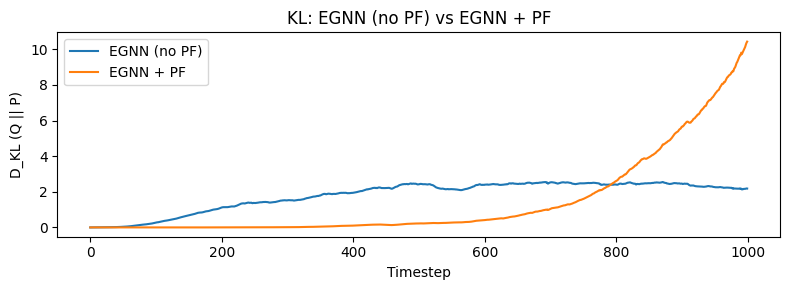

Mean KL (EGNN no PF): 1.8044956922531128
Mean KL (EGNN + PF): 1.4502564668655396


In [34]:

import torch, matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


if 'dists_GT' not in globals():
    raise RuntimeError("Please run the cell that loads validation_trajectories and defines dists_GT first.")


if 'roll_egnn' not in globals():
    egnn_no_pf = EGNN_AR_Model(h_dim=64, m_dim=64, n_layers=4, out_dim=4, edge_radius=40).to(device)
    egnn_no_pf.load_state_dict(torch.load("../../models/EGNN-NoPF.pt", map_location=device))
    egnn_no_pf.eval()
    roll_egnn = compute_ar_set_model_rollouts(
        egnn_no_pf, initial_states_validation_dataset, timesteps=1000, device=device
    )

if 'roll_pf' not in globals():
    egnn_pf_best = EGNN_AR_Model(h_dim=64, m_dim=64, n_layers=4, out_dim=4, edge_radius=40).to(device)
    egnn_pf_best.load_state_dict(torch.load("../../models/04-EGNN-PF.pt", map_location=device))
    egnn_pf_best.eval()
    roll_pf = compute_ar_set_model_rollouts(
        egnn_pf_best, initial_states_validation_dataset, timesteps=1000, device=device
    )

kl_EGNN = kl_curve(
    compute_velocity_distributions(roll_egnn[:,:,:,2:]),
    dists_GT
)
kl_PF = kl_curve(
    compute_velocity_distributions(roll_pf[:,:,:,2:]),
    dists_GT
)

plt.figure(figsize=(8,3))
plt.plot(kl_EGNN.detach().cpu().numpy(), label="EGNN (no PF)")
plt.plot(kl_PF.detach().cpu().numpy(),   label="EGNN + PF")
plt.xlabel("Timestep"); plt.ylabel("D_KL (Q || P)")
plt.title("KL: EGNN (no PF) vs EGNN + PF")
plt.legend()
plt.tight_layout()
plt.show()

print("Mean KL (EGNN no PF):", float(kl_EGNN.mean()))
print("Mean KL (EGNN + PF):", float(kl_PF.mean()))



## Evaluating scientific AI models

The Boids simulations are very sensitive to changes in the initial state. Slight changes in the initial state can lead to drastically different final states. Similarly, emulations (the neural network predictions) can accumulate errors very quickly.

Using MSE to compare models to the ground truth or to each other here does not account for this error accumulation. As a result, a likely generated/predicted trajectory can have high MSE.

Luckily for us, there are usually better ways to evaluate models! When working in an interdisciplinary group, the physics wizards will propose a metric that should hold true even when trajectories diverge, or our predictions suffer from accumulating errors.

In the Boids setting, we can investigate the distribution of velocities, since these should (hopefully) remain invariant even under diverging trajectories / error accumulation.

If we plot them visually, we want to investigate how different the predicted velocity distributions are from the ground truth velocity distributions. However, since we have to investigate the distributions for each timestep, let's use the Kullback-Leibler Divergence ($D_\text{KL}$) metric to measure the difference. For two distributions $P$ and $Q$, it is defined as follows:


$D_\text{KL}(P||Q) = \int p(x) \ln \frac{p(x)}{q(x)} \text{d} x $


![KL Divergence](https://hugocisneros.com/ox-hugo/forwardvsreversedKL.jpg)


The $D_\text{KL}$ between two distributions $P$ and $Q$ is asymmetric, meaning $D_\text{KL}(P||Q) \neq D_\text{KL}(Q||P)$, as illustrated above.

Since we care more whether the predicted distribution $Q$ fits under the ground truth distribution $P$, we will use the reverse KL: $D_\text{KL}(Q||P)$

In [ ]:
def compare_distributions(dist1, dist2):
    """
    Compare two distributions by computing the KL divergence

    Args:
        dist1: torch.distributions.Distribution
        dist2: torch.distributions.Distribution
    """
    kl = torch.distributions.kl_divergence(dist1, dist2)
    return kl

def compute_distribution_per_timestep(data, timesteps):
    """
    Compute the distribution of the data per timestep

    Args:
        data: torch.Tensor of shape (T, N, 4)
        timesteps: int, number of timesteps to compute the distribution for

    Returns:
        list of torch.distributions.Normal
    """
    distributions = []
    for t in range(timesteps):
        # Compute the mean and std of the data
        mean = data[:, t, :, :].mean()
        std = data[:, t, :, :].std()
        dist = torch.distributions.Normal(mean, std)
        distributions.append(dist)
    return distributions

def compute_mean_kl_divergence(data, distributions):
    """
    Compute the mean KL divergence between the data and the distributions

    Args:
        data: torch.Tensor of shape (T, N, 4)
        distributions: list of torch.distributions.Normal

    Returns:
        float
    """
    kl_divergences = []
    for t in range(data.shape[0]):
        kl = compare_distributions(distributions[t], data[t, :, :])
        kl_divergences.append(kl)
    return torch.tensor(kl_divergences).mean()

def plot_kl_divergence(distributions1, distributions2, title="KL Divergence between <distributions1> and <distributions2>"):
    """
    Plot the KL divergence between the data and the distributions

    Args:
        distributions1: list of torch.distributions.Normal
        distributions2: list of torch.distributions.Normal
    """
    kl_divergences = []
    for t in range(len(distributions1)):
        kl = compare_distributions(distributions1[t], distributions2[t]).cpu().numpy()
        kl_divergences.append(kl)


    plt.plot(kl_divergences)
    plt.xlabel("Timestep")
    plt.ylabel("KL Divergence")
    plt.title(title)
    plt.show()

In [ ]:
validation_files = [pfn for pfn in os.listdir("../../data/boids/raw/") if (16 <= int(pfn.split("_")[-1][:-4]) < 25)]
validation_trajectories = [np.load("../../data/boids/raw/" + f) for f in validation_files]
validation_trajectories = torch.tensor(validation_trajectories, dtype=torch.float)

dists_GT = compute_distribution_per_timestep(validation_trajectories[:,:,:,2:], 1000)
dists_AR_set = compute_distribution_per_timestep(ar_set_model_rollout[:,:,:,2:], 1000)
plot_kl_divergence(dists_AR_set, dists_GT, title="KL Divergence between AR Set Model velocities and the GT velocities per timestep")



In [ ]:
dists_equivariant = compute_distribution_per_timestep(translational_equivariant_model_rollout, 1000)
plot_kl_divergence(dists_equivariant, dists_GT, title="KL Divergence between Translational Equivariant Model velocities and the GT velocities per timestep")

# References

[1] Minartz, K., Poels, Y., Koop, S., & Menkovski, V. (2023). Equivariant Neural Simulators for Stochastic Spatiotemporal Dynamics. https://openreview.net/forum?id=CCVsGbhFdj

[2] Reynolds, C. W. (1987) Flocks, Herds, and Schools: A Distributed Behavioral Model, in Computer Graphics, 21(4) (SIGGRAPH '87 Conference Proceedings) pages 25-34.

[3] Satorras, V. G., Hoogeboom, E., & Welling, M. (2021, July). E (n) equivariant graph neural networks. In International conference on machine learning (pp. 9323-9332). PMLR.